<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [23]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [24]:
df_numericas = df.select_dtypes(include=['int64', 'float64']).copy()
df_numericas = df_numericas.fillna(df_numericas.mean())
scaler = MinMaxScaler()
df_numericas_normalizadas = pd.DataFrame(scaler.fit_transform(df_numericas),
                                         columns=df_numericas.columns)

In [25]:
df_categoricas = df.select_dtypes(include=['object', 'category']).copy()
df_categoricas_cod = pd.get_dummies(df_categoricas, drop_first=True)

In [26]:
df_procesado = pd.concat([df_numericas_normalizadas, df_categoricas_cod], axis=1)

### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [27]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(df_procesado)
df_procesado['cluster'] = kmeans.labels_
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns[:-1])

In [28]:
promedios_cluster = df_procesado.groupby('cluster').mean(numeric_only=True)
moda_cluster = df_procesado.groupby('cluster').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

In [29]:
print("Centroides de los clusters:\n", centroides)
print("\nPromedio por cluster:\n", promedios_cluster)
print("\nModa por cluster:\n", moda_cluster)

Centroides de los clusters:
        year  desplazamiento  cilindros       co2  consumo_litros_milla  \
0  0.451659        0.238421   0.177987  0.304232              0.226257   
1  0.568688        0.168773   0.145300  0.241157              0.156687   
2  0.576884        0.360765   0.298904  0.354767              0.283137   
3  0.313071        0.548444   0.383841  0.507836              0.453114   
4  0.405352        0.331349   0.256734  0.354443              0.282215   
5  0.683067        0.296988   0.251457  0.319516              0.243687   
6  0.448508        0.418381   0.300188  0.405085              0.338074   
7  0.597842        0.625181   0.475404  0.482405              0.417440   

   clase_tipo_Coche Familiar  clase_tipo_Coches Grandes  \
0                   0.103530                   0.049583   
1                   0.117846                   0.017589   
2                   0.086086                   0.078023   
3                   0.001971                   0.016203   
4        

### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

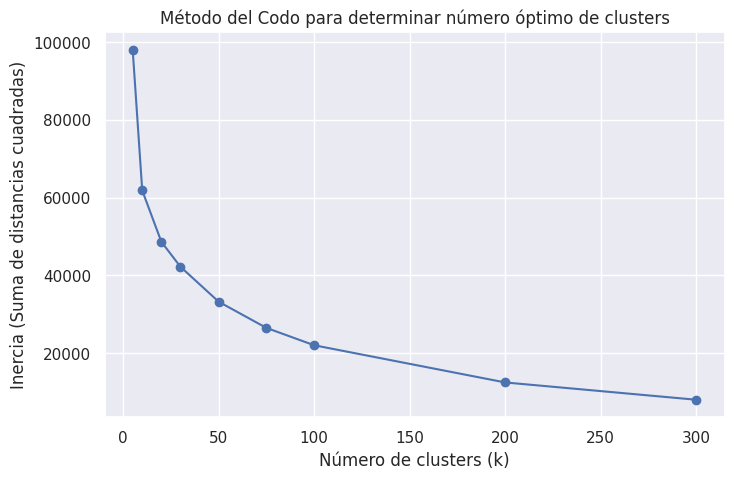

In [30]:
k_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_procesado)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.title('Método del Codo para determinar número óptimo de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.grid(True)
plt.show()

En el gráfico se observa cómo la inercia disminuye rápidamente al aumentar el número de clusters, pero luego la mejora marginal se vuelve pequeña.
El punto donde la curva empieza a “doblarse” indica el número óptimo de clusters.
En este caso, se debe seleccionar el
𝑘
k donde la reducción de inercia deja de ser significativa (k ≈ 20–30, según eñ grafico)

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [31]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [32]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



In [33]:
X = wine.drop(columns=['wine_class']).values
y = wine['wine_class'].values
feature_names = wine.drop(columns=['wine_class']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp_acum)+1), var_exp_acum, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% varianza explicada')
plt.axhline(0.95, color='g', linestyle='--', label='95% varianza explicada')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada (Wine - PCA)')
plt.legend()
plt.grid(True)
plt.show()

num_componentes_90 = np.argmax(var_exp_acum >= 0.90) + 1
print(f"Número de componentes necesarios para explicar ≥90%: {num_componentes_90}")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)
print("\nLoadings (primeras 5 variables):")
print(loadings.iloc[:5, :5])
pca_2d = PCA(n_components=2)
proyeccion_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for clase in np.unique(y):
    plt.scatter(proyeccion_2d[y == clase, 0], proyeccion_2d[y == clase, 1], s=30, alpha=0.8, label=f'Clase {clase}')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Proyección 2D del dataset Wine mediante PCA')
plt.legend()
plt.grid(True)
plt.show()

El análisis PCA muestra que con un número reducido de componentes (alrededor de 2 o 3) se logra explicar más del 90 % de la varianza total, lo que indica que gran parte de la información original se concentra en pocas dimensiones. Los loadings revelan qué variables tienen mayor peso en las nuevas componentes,por ejemplo, aquellas relacionadas con el contenido de alcohol, fenoles y color son las que más influyen en la primera componente.

 Al proyectar los datos en dos dimensiones, se observa una separación parcial de las tres variedades de vino, lo que sugiere que el PCA logra capturar patrones relevantes que distinguen las clases.



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



In [34]:
X = wine.drop(columns=['wine_class']).values
y = wine['wine_class'].values
X_scaled = scaler.fit_transform(X)
perplexidades = [5, 30, 50]
learning_rates = [100, 200, 500]

fig, axes = plt.subplots(len(perplexidades), len(learning_rates), figsize=(14, 10))
fig.suptitle('Wine - Visualización t-SNE con diferentes hiperparámetros', fontsize=14)
for i, perp in enumerate(perplexidades):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=42)
        emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        for clase in np.unique(y):
            sel = y == clase
            ax.scatter(emb[sel, 0], emb[sel, 1], s=15, alpha=0.8, label=f'Clase {clase}')
        ax.set_title(f'Perp={perp}, LR={lr}')
        ax.set_xticks([]); ax.set_yticks([])
        if i == 0 and j == 0:
            ax.legend(markerscale=1.5, fontsize=8)

plt.tight_layout()
plt.show()

El método t-SNE permite representar los datos en 2D capturando relaciones no lineales que el PCA no refleja.
Al variar los hiperparámetros, se observa que valores intermedios de perplexity (≈30) y learning rate (≈200) generan agrupaciones más estables y bien definidas.
Las tres clases de vinos tienden a separarse en regiones distintas del plano, mostrando que t-SNE logra distinguir mejor las estructuras locales y resaltar diferencias entre variedades, a diferencia de PCA, que se centra en la varianza global.



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



El PCA sirve para reducir la cantidad de variables manteniendo la mayor parte de la información, y al ser un método lineal es fácil de interpretar y útil para ver relaciones generales entre los datos. Pero tiene la desventaja de que no capta patrones complejos o no lineales. En cambio, el t-SNE es un método no lineal que se enfoca más en las relaciones locales, mostrando agrupaciones o estructuras que el PCA no logra ver, aunque depende bastante de los hiperparámetros y no es tan fácil de interpretar. En general, usaría PCA cuando quiero entender qué variables son más importantes o reducir la dimensionalidad antes de aplicar un modelo, y t-SNE cuando quiero explorar visualmente los datos y ver si hay grupos ocultos. Ambos ayudan a simplificar el análisis, reducir ruido y entender mejor la información en datasets grandes